Filtro per Fake News
Il problema delle fake news è cresciuto esponenzialmente nell'ultimo decennio a causa della crescente diffusione dei social network, il governo degli Stati Uniti ha deciso di muoversi a tal proposito, incaricando la tua azienda di realizzare un plug-in per chrome in grado di riconoscere se una notizia è falsa. Il tuo compito è quello di realizzare il modello in grado di riconoscere le notizie false, che poi il team di machine learning enginner e web developer metterà in produzione. Ti vengono messi a disposizioni due raccolte di notizie, una contenente solo notizie false e l'altra contenente solo notizie vere, utilizzale per addestrare il tuo modello.

Parti da un'accurata analisi, rispondendo a domande come:

le fake news sono più frequenti in una determinata categoria?
per ogni categoria, ci sono argomenti che sono più soggetti alle fake news?
I titoli delle fake news presentano dei pattern?
Una volta addestrato il modello esportalo utilizzando pickle così che i tuoi colleghi possano metterlo in produzione.

In [ ]:
!wget https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip
!unzip fake_news.zip

--2024-04-25 08:45:28--  https://proai-datasets.s3.eu-west-3.amazonaws.com/fake_news.zip
Resolving proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)... 52.95.156.98, 16.12.18.26
Connecting to proai-datasets.s3.eu-west-3.amazonaws.com (proai-datasets.s3.eu-west-3.amazonaws.com)|52.95.156.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42975911 (41M) [application/zip]
Saving to: ‘fake_news.zip’

fake_news.zip       100%[===================>]  40.98M  20.0MB/s    in 2.0s    

2024-04-25 08:45:31 (20.0 MB/s) - ‘fake_news.zip’ saved [42975911/42975911]

Archive:  fake_news.zip
  inflating: Fake.csv                
  inflating: True.csv                


In [ ]:
import pandas as pd

In [ ]:
df_true = pd.read_csv("True.csv")
df_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [ ]:
df_fake = pd.read_csv("Fake.csv")
df_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [ ]:
# Aggiungiamo una colonna per l'origine dei dati ed uniamo i df
df_fake['fake'] = 1
df_true['fake'] = 0

df = pd.concat([df_fake, df_true], ignore_index=True)

In [ ]:
import re

# Pulizia del testo, rimuovendo caratteri speciali e riducendo tutto in minuscolo
def clean_text(text):

    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = text.lower()
    return text

df['text'] = df['text'].apply(clean_text)
df['title'] = df['title'].apply(clean_text)

In [ ]:
#verifica pulizia avvenuta correttamente
first_title = df.loc[0, 'title']
print(first_title)

 donald trump sends out embarrassing new years eve message this is disturbing


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
import pickle

# Dividi il dataset in variabili indipendenti (X) e dipendenti (y)
X = df['text']
y = df['fake']

# Dividi il dataset in set di addestramento e test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vettorizza i dati di testo
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Addestra il modello
model = LinearSVC()
model.fit(X_train_vec, y_train)

# Valutazione il modello
accuracy = model.score(X_test_vec, y_test)
print("Accuracy:", accuracy)

# Esportazione
with open('fake_news_model.pkl', 'wb') as f:
    pickle.dump(model, f)

Accuracy: 0.9959910913140312


In [ ]:
# Value counts per la colonna 'subject' per individuare le fake news più frequenti in una determinata categoria
subject_counts = df[df['fake'] == 1]['subject'].value_counts()
print("Fake News più frequenti per categoria:")
print(subject_counts)

Fake News più frequenti per categoria:
subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64


In [ ]:
df_fake['subject'].count()

23481

La categoria affetta da più fake news è il subject "News" con con 9050 casistiche su un totale di 23481.

In [ ]:
#individuaiamo i topic del nostro df_fake in modo da vedere quali argomenti sono più frequenti per categori subject
doc = df_fake['title'] +' '+ df_fake['text']+' '+df_fake['subject']

In [ ]:
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

#pulizia
def sent_to_words(items):
  for item in items:
    yield(simple_preprocess(item, deacc=True))

def remove_stopwords(texts):
  return[[word for word in words if word not in stop_words and len(words) >= 5] for words in texts]

data_words = list(sent_to_words(doc))

data_words = remove_stopwords(data_words)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#vettorizzazione
import gensim.corpora as corpora
id2word = corpora.Dictionary(data_words)
corpus = [id2word.doc2bow(text) for text in data_words]

In [ ]:
#creazione dei topic
import gensim
from pprint import pprint
num_topics = 4

lda_model = gensim.models.LdaMulticore(corpus = corpus,
                                      id2word = id2word,
                                      num_topics = num_topics,
                                      passes = 3
                                      )

pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.006*"said" + 0.005*"police" + 0.005*"us" + 0.004*"one" + 0.004*"news" + '
  '0.003*"wire" + 0.003*"people" + 0.003*"also" + 0.003*"would" + '
  '0.003*"year"'),
 (1,
  '0.008*"clinton" + 0.006*"state" + 0.005*"obama" + 0.005*"would" + '
  '0.005*"hillary" + 0.004*"government" + 0.004*"president" + 0.004*"new" + '
  '0.004*"one" + 0.004*"states"'),
 (2,
  '0.019*"trump" + 0.007*"news" + 0.007*"people" + 0.006*"video" + '
  '0.006*"like" + 0.005*"president" + 0.005*"one" + 0.005*"twitter" + '
  '0.005*"left" + 0.004*"donald"'),
 (3,
  '0.019*"trump" + 0.008*"president" + 0.008*"news" + 0.007*"clinton" + '
  '0.007*"us" + 0.007*"media" + 0.006*"russia" + 0.006*"said" + '
  '0.005*"hillary" + 0.005*"russian"')]


Topic 0:
Parole chiave: trump, president, obama, us, news, fbi, said, clinton, twitter, syria
Possibile tema: Politica statunitense e attività del presidente Trump e dell'ex presidente Obama

Topic 1:
Parole chiave: trump, clinton, hillary, news, donald, president, said, campaign, election, one
Possibile tema: Elezioni presidenziali statunitensi e campagna elettorale

Topic 2:
Parole chiave: said, police, black, people, news, one, video, left, like, year
Possibile tema: Questioni legate alla polizia, alla comunità nera e alla società

Topic 3:
Parole chiave: government, state, obama, would, said, people, states, president, us, american
Possibile tema: Politica governativa e questioni statali negli Stati Uniti

In [ ]:
#vediamo se il modello riesce ad assegnare correttamente i topic
title = id2word.doc2bow(simple_preprocess(df_fake['text'][0]))
for index, score in lda_model[title]:
    print("TOPIC: "+str(index))
    print("SCORE:"+str(score))

TOPIC: 2
SCORE:0.9967528


In [ ]:
from gensim.corpora import Dictionary

# Creare il dizionario basato sui testi del DataFrame df_fake
dictionary = Dictionary(df_fake['text'].apply(lambda x: x.split()))

# Rimuovere le parole raramente utilizzate e le stop words
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

# Creazione del corpus per il DataFrame df_fake
corpus_fake = [dictionary.doc2bow(text.split()) for text in df_fake['text']]

# Ottenere la distribuzione di probabilità dei topic per ciascun documento
topic_distribution = [lda_model.get_document_topics(doc) for doc in corpus_fake]

# Estrai il topic dominante per ciascun documento
dominant_topic = [max(topic_dist, key=lambda x: x[1])[0] for topic_dist in topic_distribution]

# Aggiungi la colonna dei cluster al DataFrame df_fake
df_fake['cluster'] = dominant_topic

In [ ]:
# Definizione del dizionario che associa i numeri di topic ai nomi desiderati
topic_names = {
    0: "Politica e attività del presidente Trump e dell'ex presidente Obama",
    1: "Elezioni presidenziali statunitensi",
    2: "Polizia, comunità nera e società",
    3: "Politica governativa e questioni statali negli Stati Uniti"
}


df_fake['topic_name'] = df_fake['cluster'].map(topic_names)

In [ ]:
df_fake[:6]

,title,text,subject,date,fake,cluster,topic_name
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,2,"Polizia, comunità nera e società"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,3,Politica governativa e questioni statali negli...
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,2,"Polizia, comunità nera e società"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,2,"Polizia, comunità nera e società"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,0,Politica e attività del presidente Trump e del...
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",1,3,Politica governativa e questioni statali negli...


In [ ]:
# Raggruppa per 'subject' e 'topic'
grouped = df_fake.groupby(['subject', 'topic_name']).size().reset_index(name='count')

# Ordina i risultati
grouped_sorted = grouped.sort_values(by=['subject', 'count'], ascending=[True, False])
grouped_sorted

,subject,topic_name,count
3,Government News,"Polizia, comunità nera e società",1046
1,Government News,Politica e attività del presidente Trump e del...,291
2,Government News,Politica governativa e questioni statali negli...,189
0,Government News,Elezioni presidenziali statunitensi,44
7,Middle-east,"Polizia, comunità nera e società",572
4,Middle-east,Elezioni presidenziali statunitensi,86
5,Middle-east,Politica e attività del presidente Trump e del...,85
6,Middle-east,Politica governativa e questioni statali negli...,35
11,News,"Polizia, comunità nera e società",7540
10,News,Politica governativa e questioni statali negli...,783


In [ ]:
count_topic = df_fake['topic_name'].count()
count_topic

23481

In [ ]:
count_topic_1 = (df_fake['topic_name'] == 'Polizia, comunità nera e società').sum()
count_topic_1

17539

In [ ]:
(count_topic_1/count_topic)*100

74.69443379753844

Possiamo osservare che i topic maggiormente vittima delle fake news per le categorie in oggetto sono:
- Government News: Polizia, comunità nera e società con 1046 fake news;
- Middle-east: Polizia, comunità nera e società con 572 fake news;
- News: Polizia, comunità nera e società con 7540 fake news;
- US_News:  Polizia, comunità nera e società con 577 fak news;
- left-news: Polizia, comunità nera e società con 3218 fake news;
- politics: Polizia, comunità nera e società con	4586 fake news.

Dunque il topic maggiormente vittima di fake news è "Polizia, comunità nera e società" con ben 17539 fake news su 23481 ovvero il 74,69%

Cluster di parole più frequenti per Government News


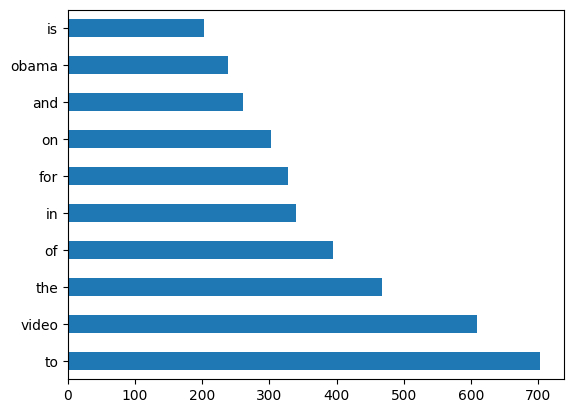

Cluster di parole più frequenti per Middle-east


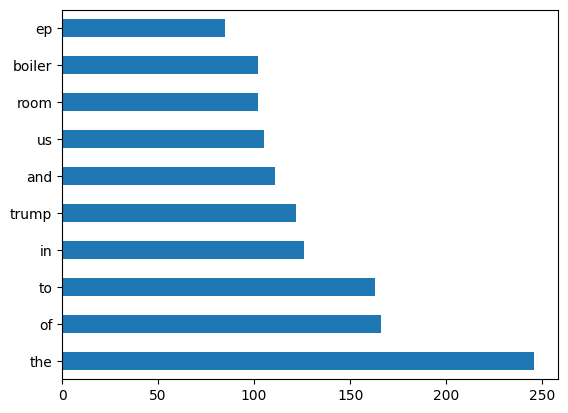

Cluster di parole più frequenti per News


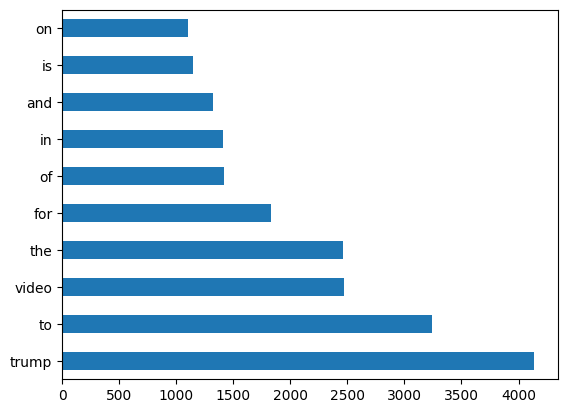

Cluster di parole più frequenti per US_News


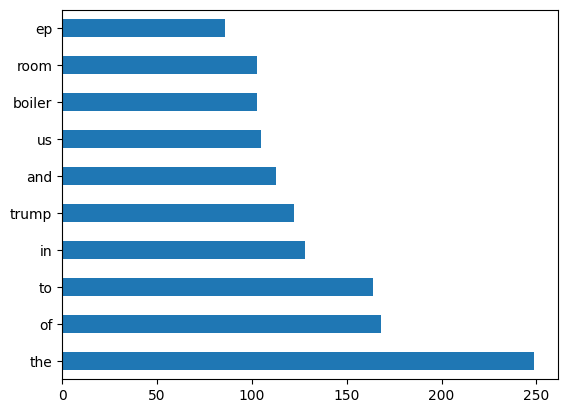

Cluster di parole più frequenti per left-news


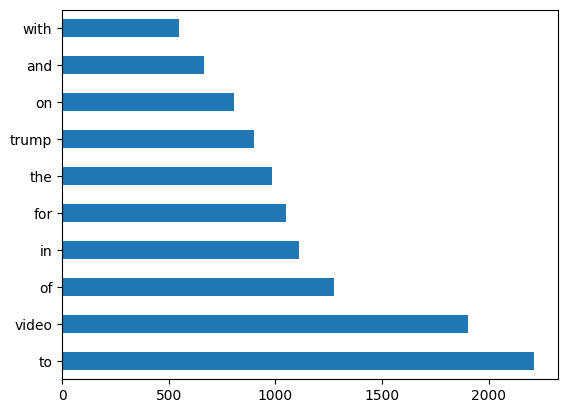

Cluster di parole più frequenti per politics


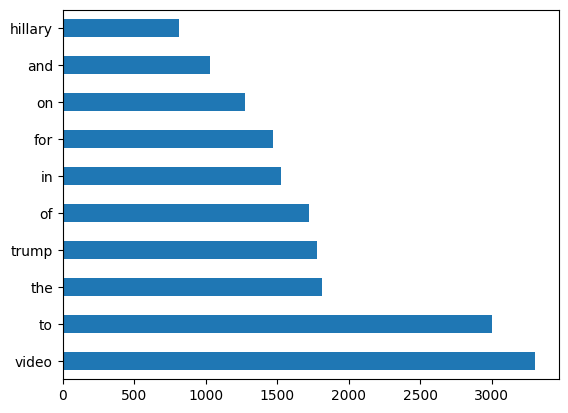

In [ ]:
# Per vedere se i titoli delle fake news presentano dei pattern

from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt

# Raggruppa i testi per categoria
fake_news_by_subject = df[df['fake'] == 1].groupby('subject')['title'].apply(' '.join)

# Vettorizza i dati di testo per ogni categoria
vectorizer = CountVectorizer()
X_fake_vec = vectorizer.fit_transform(fake_news_by_subject)

# Trova le parole più frequenti per categoria
word_freq = pd.DataFrame(X_fake_vec.toarray(), columns=vectorizer.get_feature_names_out())
word_freq.index = fake_news_by_subject.index

# Visualizza i cluster di parole più frequenti per categoria
for subject in word_freq.index:
    print("Cluster di parole più frequenti per", subject)
    word_freq.loc[subject].sort_values(ascending=False).head(10).plot(kind='barh')
    plt.show()
